## Installations

In [1]:
import pyspark
sc = spark.sparkContext

print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
print('Original spark.driver.maxMemory: ' + sc._conf.get('spark.driver.memory'))

spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

Original spark.driver.maxResultSize: 1920m
Original spark.driver.maxMemory: 3840m


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')


!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


import os
import shutil
import pandas as pd
# import sh
#from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from google.cloud import storage
import datetime
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 234.1 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
Edtweet_org2 = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/imajumd0/Edtweet_org")                       

In [6]:
twitter_raw_full = spark.read.json("gs://msca-bdp-tweets/final_project/")

23/05/23 12:59:44 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/05/23 13:05:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 13 for reason Container marked as failed: container_1684846236830_0001_01_000013 on host: hub-msca-bdp-dphub-students-backup-imajumd0-sw-3jgm.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/05/23 13:05:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 12 for reason Container marked as failed: container_1684846236830_0001_01_000012 on host: hub-msca-bdp-dphub-students-backup-imajumd0-sw-3jgm.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: 

In [ ]:
#write
Edtweet_org_ML.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/imajumd0/Edtweet_org_ML')

In [ ]:
#read
Edtweet_org_ML = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/imajumd0/Edtweet_org_ML")                       

In [3]:
#if edTweet_org has no retweeted, then use the retweeted subset dataset
#read
retweeted_subset = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/imajumd0/retweeted_subset")
#add org_type to retweeted status

23/05/23 12:56:42 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Data Transformations

In [45]:
#Get back the retweeted variable from the original dataset
Edtweet_org_retweeted2 = Edtweet_org2.join(twitter_raw_full['retweeted', 'id'], F.col('id') == F.col('tweet_id'), 'left')

In [60]:
Edtweet_org_Null = Edtweet_org_retweeted2.filter(F.col('retweeted') == '').sample(fraction=0.05, seed=0)


In [62]:
Edtweet_org_Null = Edtweet_org_Null.select('org_type', 'user.statuses_count', 'tweet_id', 'tweet_text', 'retweeted') \
                               .withColumn('retweeted_encoded', F.when(Edtweet_org_Null.retweeted == 'RT', 1).otherwise(0)) \
                               .persist()

In [47]:
#Get back the retweeted variable from the original dataset
Edtweet_org_retweeted = retweeted_subset.join(twitter_raw_full['retweeted', 'id'], F.col('id') == F.col('tweet_id'), 'left')
#then we take the retweeted subset to develop Edtweet_org, which includes org_type

In [64]:
#We got Edtweet_org from Edtweet_org_retweeted by creating the organization type feature as below
Edtweet_org_RT = Edtweet_org.filter(F.col('retweeted') == 'RT').sample(fraction=0.0007, seed=0)

In [65]:
Edtweet_org_RT = Edtweet_org_RT.select('org_type', 'user.statuses_count', 'tweet_id', 'tweet_text', 'retweeted') \
                               .withColumn('retweeted_encoded', F.when(Edtweet_org_RT.retweeted == 'RT', 1).otherwise(0)) \
                               .persist()

23/05/23 14:42:57 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [66]:
#we merge these two datasets to create a balanced sample for ML
Edtweet_org_ML = Edtweet_org_RT.unionAll(Edtweet_org_Null)

In [68]:
Edtweet_org_ML.cache()

org_type,statuses_count,tweet_id,tweet_text,retweeted,retweeted_encoded
The Masses,83364,1512261684122902532,This is what's go...,RT,1
The Masses,3060,1513880897950564365,Be careful on you...,RT,1
The Masses,171,1514044698255630342,This is not from ...,RT,1
The Masses,64835,1514448936274210816,I cannot say this...,RT,1
The Masses,24552,1515091403164069888,Outing school age...,RT,1
The Masses,262947,1516190968436989960,New client profil...,RT,1
The Masses,4300,1516927767564230656,PSA: Awe= a feel...,RT,1
The Masses,27894,1519160653734309888,My 17 y.o. slippe...,RT,1
The Masses,6448,1520232719527067651,Appears #NHLDucks...,RT,1
The Masses,11031,1522326224294490113,So asking a kid i...,RT,1


In [69]:
retweeted_twt = Edtweet_org_ML.filter(F.col('retweeted_encoded') == 1).count()
origin_twt = Edtweet_org_ML.filter(F.col('retweeted_encoded') == 0).count()

print(f"Tweets that are retweets: {retweeted_twt}")
print(f"Tweets that are original: {origin_twt}")

Tweets that are retweets: 25992
Tweets that are original: 30922


## Develop a feature for organization type

In [48]:
# This code was run in a previous analysis, but is placed here for reference. The function defines the rules to categorize user account types i.e. 'org_type'
def tag_user(profile):
    try:
        followers_count = profile['followers_count']
        verified_status = profile['verified']
        user_description = profile['description']
        user_name = profile['name']
        url = profile['url']

        org_type = 'The Masses'

        if followers_count > 12500 and verified_status == 0 and any(keyword in user_description.lower().split() for keyword in ['influencer', 'coach', 'blogger', 'author', 'certified', 'consultant', 'edtech', 'speaker', 'trainer', 'founder', 'professor', 'attorney', 'writer', 'entrepreneur', 'curriculum developer', 'specialist', 'researcher', 'analyst', 'teacher', 'educator', 'faculty', 'professor']):
            org_type = 'EdTech Influencer'
        elif url is not None and '.gov' in url:
            org_type = 'Govt/State-affiliated'
        elif verified_status == 1 and any(keyword in user_description.lower().split() for keyword in ['nominee', 'state', 'rep', 'democratic', 'republican', 'independent', 'senator', 'representative', 'candidate', 'fellow', 'board', 'state', 'governor', 'mayor', 'congressman', 'congresswoman', 'parliamentarian', 'diplomat', 'activist', 'elected', 'political', 'organizer', 'cabinet', 'policy', 'justice', 'civil', 'policy', 'constituency', 'election', 'legislation', 'bipartisan', 'progressive', 'conservative', 'liberal', 'libertarian', 'grassroots', 'campaign', 'constituent', 'public']):
            org_type = 'Politicians'
        elif 'jobs' in user_name.lower():
            org_type = 'Job-Boards'
        elif verified_status == 1 and any(keyword in user_description.lower().split() for keyword in ['journalism', 'media', 'news']):
            org_type = 'News Orgs'
        elif any(keyword in user_description.lower().split() for keyword in ['school', 'schools', 'university', 'community college', 'board', 'official']) and ('.edu' in url or '.org' in url):
            org_type = 'Edu-Institution'
        elif any(keyword in user_description.lower().split() for keyword in ['president', 'member', 'director', 'superintendent', 'chancellor', 'provost', 'dean', 'headmaster', 'headmistress', 'academic director', 'chief academic officer', 'chief learning officer', 'coordinator', 'chair', 'administrator', 'director', 'manager']):
            org_type = 'Leaders in Ed'
        elif followers_count > 150000:
            org_type = 'Other Influencer'

        return org_type
    except Exception as e:
        row_number = profile['id']
        print("NoneType error at user_id:", row_number)
        return None


In [49]:
# Define the UDF wrapper for the tag_user function
tag_user_udf = F.udf(tag_user, StringType())

# Apply the tag_user function using withColumn
Edtweet_org = Edtweet_org_retweeted.filter(F.col('user')['description'].isNotNull()) \
                                   .withColumn('org_type', tag_user_udf(F.col('user')))

In [50]:
# Deal with null values
Edtweet_org = Edtweet_org.withColumn('org_type', F.when(F.col('org_type').isNull(), 'The Masses').otherwise(F.col('org_type')))

## Develop a feature to assess originality of a Tweet. We will use Jaccard Similarity

In [70]:
#create a function that takes as inputs - J.sim threshold, a single column named 'text' - and produces duplicates, uniques
def jsim_by_org(df_text_raw, max_dist_threshold):
  
    rdd_text = df_text_raw.select("id", "text").rdd.filter(lambda x: x['text'] is not None)
    
    StopWords = stopwords.words("english")
    tokens = rdd_text \
    .map(lambda x: (x['id'], x['text'].strip().lower().split())) \
    .map(lambda x: (x[0], [word for word in x[1] if len(word) > 1])) \
    
    row = Row('text')
    df_tokens = spark.createDataFrame(tokens, ["id", "list_of_words"])
    df_tokens = df_tokens.where(F.col('list_of_words').getItem(0).isNotNull())
    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()
    df_hashed_text = df_text_raw.join(df_hashed, "id", how = 'left')
    
    df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, max_dist_threshold).filter("datasetA.id < datasetB.id").select(
                F.col("distCol"),
                F.col("datasetA.id").alias("id_A"),
                F.col("datasetB.id").alias("id_B"),
                F.col('datasetA.text').alias('text_A'),
                F.col('datasetB.text').alias('text_B'))
    df_dups_text.cache()
    records = df_hashed_text.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    return df_dups_text

In [72]:
Jaccard_text_raw = Edtweet_org_ML.select('tweet_text', 'tweet_id') \
                                 .withColumnRenamed('tweet_text', 'text') \
                                 .withColumnRenamed('tweet_id', 'id')

#Jaccard_text_raw.show()

In [ ]:
df_dups_edtweet60  = jsim_by_org(Jaccard_text_raw, .60)

23/05/23 14:48:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 14:49:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 14:49:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 14:50:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 15:41:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:41:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [75]:
# For each tweet, we take the min(distCol). Two identical tweets will have DistCol = 0, since it is a measure of how far apart two tweets are. 
# Even if a tweet is identical to one other tweet, we consider it "not original". So we take the min(Distcol) 
dups_id_distcol = df_dups_edtweet60.select('id_A', 'distCol') \
                                   .groupBy('id_A') \
                                   .agg(F.min('distCol'))

In [76]:
#for the right tweet_id, add back the distCol variable from df_dups_edtech60 to the original Edtweet_org_ML dataset.
#Take the minimum distCol for each tweet_id

Edtweet_org_ML = Edtweet_org_ML.join(dups_id_distcol, F.col('id_A') == F.col('tweet_id'), 'left')

In [77]:
Edtweet_org_ML = Edtweet_org_ML.withColumnRenamed('min(distCol)', 'Jac_distance')

In [78]:
Edtweet_org_ML.printSchema()
#check the name of statuses_count and check the type for the target variable (integer?)

root
 |-- org_type: string (nullable = true)
 |-- statuses_count: long (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweeted_encoded: integer (nullable = false)
 |-- id_A: long (nullable = true)
 |-- Jac_distance: double (nullable = true)



In [33]:
#unique tweets
Edtweet_org_ML.filter(F.col('Jac_distance').isNull()).count()

23/05/23 01:41:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1895.9 KiB
23/05/23 01:41:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1895.8 KiB


26590

In [79]:
#make the Jac_distance column = 1 if the tweet was identified as an original by our function
Edtweet_org_ML = Edtweet_org_ML.withColumn('Jac_distance', F.when(F.col('Jac_distance').isNull(), 1).otherwise(F.col('Jac_distance')))

In [34]:
# all tweets
Edtweet_org_ML.count()

23/05/23 01:43:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1889.4 KiB
23/05/23 01:43:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1892.6 KiB


30922

In [36]:
#duplicate tweets
df_dups_edtweet60.select('id_A').distinct().count()

23/05/23 01:44:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1889.1 KiB
23/05/23 01:44:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.1 KiB


4332

In [38]:
#Did it work?
Edtweet_org_ML.filter(F.col('Jac_distance').isNull()).count()

23/05/23 01:48:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.0 KiB
23/05/23 01:48:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.2 KiB


0

# Preparing the data for Pyspark MLIB ingestion

## One-hot encoding of categorical variable, org_type

In [82]:
#VectorAssembler needs to understand org_type as a categorical variable, so we one-hot encode it. 
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# StringIndexer to convert 'org_type' to numeric indices
stringIndexer = StringIndexer(inputCol='org_type', outputCol='org_type_index')
indexedData = stringIndexer.fit(Edtweet_org_ML).transform(Edtweet_org_ML)

# OneHotEncoder to one-hot encode the indexed column
oneHotEncoder = OneHotEncoder(inputCols=['org_type_index'], outputCols=['org_type_encoded'])
encodedData = oneHotEncoder.fit(indexedData).transform(indexedData)

23/05/23 15:43:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [50]:
encodedData.show()

23/05/23 02:14:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.0 KiB
23/05/23 02:14:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1895.8 KiB


+----------+--------------+-------------------+--------------------+-----------------+-------------------+------------------+--------------+----------------+--------------------+
|  org_type|statuses_count|           tweet_id|          tweet_text|retweeted_encoded|               id_A|      Jac_distance|org_type_index|org_type_encoded|            features|
+----------+--------------+-------------------+--------------------+-----------------+-------------------+------------------+--------------+----------------+--------------------+
|The Masses|        176361|1529251476236689408|Thoughts and pray...|                0|               null|               1.0|           0.0|   (8,[0],[1.0])|(10,[0,8,9],[1.0,...|
|The Masses|          8066|1530178720228593664|@dwp4401 Police i...|                0|               null|               1.0|           0.0|   (8,[0],[1.0])|(10,[0,8,9],[1.0,...|
|The Masses|           112|1529573741252030471|From first day to...|                0|               null

In [83]:
from pyspark.ml.feature import VectorAssembler

In [84]:
# Select the desired features and use VectorAssembler
features = ['org_type_encoded', 'statuses_count', 'Jac_distance']
assembler = VectorAssembler(inputCols=features, outputCol='features')
encodedData = assembler.transform(encodedData)
#Edtweet_org_ML[['org_type', 'statuses_count', 'distCol', 'features']].show()

# Running Logistic Regression to Predict Whether a Tweet will be Retweeted

In [ ]:
from pyspark.ml.classification import LogisticRegression

train, test = encodedData.randomSplit([0.7, 0.3], seed=7)

lr = LogisticRegression(featuresCol='features', labelCol='retweeted_encoded')
model = lr.fit(train)

23/05/23 15:43:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 15:43:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 15:44:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 15:44:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 15:44:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 15:44:43 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.gi

In [ ]:
# Training Summary Data
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

23/05/23 16:03:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 16:03:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 16:03:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/05/23 16:03:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [ ]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

23/05/23 16:03:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/05/23 16:03:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Training AUC: 0.6728374087056163


23/05/23 16:04:19 ERROR org.apache.spark.scheduler.AsyncEventQueue: Dropping event from queue eventLog. This likely means one of the listeners is too slow and cannot keep up with the rate at which tasks are being started by the scheduler.
23/05/23 16:04:19 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1 events from eventLog since the application started.


Test AUC:  0.6709072096827704

False positive rate by label (Training):


23/05/23 16:04:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB


label 0: 0.64336434193868
label 1: 0.1731892389054955

True positive rate by label (Training):
label 0: 0.8268107610945045
label 1: 0.35663565806131997

Training Accuracy: 0.6127981559430747


23/05/23 16:04:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Test Accuracy:  0.6090459945888719


In [88]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

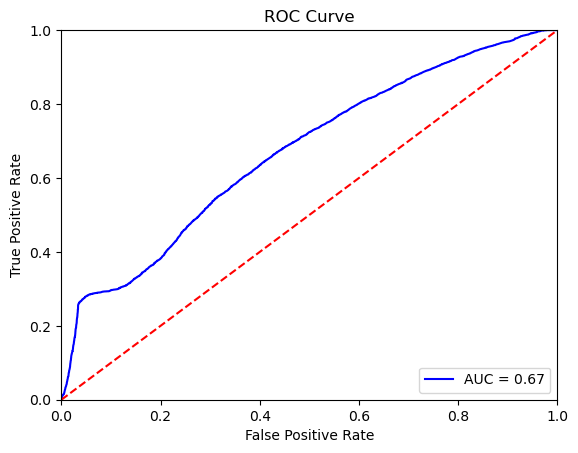

UsageError: Line magic function `%matplot` not found.


In [89]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', 
         label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt